In [1]:
%matplotlib inline
from beep.structure.cli import auto_load_processed
from beep.structure.cli import auto_load
import json
import numpy as np
import pandas as pd
from monty.serialization import loadfn, dumpfn
from glob import glob
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import cm,colors
import seaborn as sns
import os
# from throughput_dev_tri import get_threshold_targets
import pickle
from scipy.interpolate import interp1d
from scipy import optimize
from scipy.optimize import differential_evolution
# from dtw import *
# from IntracellAnalysis import *
import itertools
# from beep.dataset import BeepDataset
from functools import reduce

import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut 
from sklearn.model_selection import cross_val_score,KFold

from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

from sklearn.svm import SVR
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.kernel_ridge import KernelRidge
import shap 
# Set the number of neurons/nodes for each layer:
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import regularizers

2022-06-06 20:45:46.737568: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/opt/amazon/efa/lib64:/opt/amazon/openmpi/lib64:/usr/local/lib:/usr/lib:/lib:/usr/local/cuda/lib:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/opt/amazon/efa/lib64:/opt/amazon/openmpi/lib64:/usr/local/lib:/usr/lib:/lib:
2022-06-06 20:45:46.737593: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
X_train  = pd.read_csv("split_1_train_X_Tesla_Cells_20220428.csv")
X_test  = pd.read_csv("split_1_test_X_Tesla_Cells_20220428.csv")
y_train  = pd.read_csv("split_1_train_y_Tesla_Cells_20220428.csv")
y_test  = pd.read_csv("split_1_test_y_Tesla_Cells_20220428.csv")

Text(0.5, 1.0, 'Data distribution')

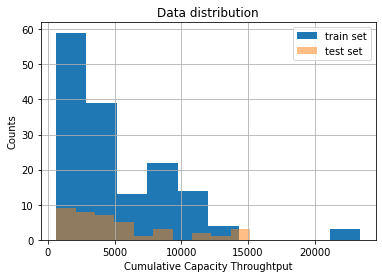

In [4]:
y_train['rpt_0.2Cdischarge_capacity0.8_real_regular_throughput::DiagnosticProperties'].hist()
y_test['rpt_0.2Cdischarge_capacity0.8_real_regular_throughput::DiagnosticProperties'].hist(alpha = 0.5)
plt.xlabel('Cumulative Capacity Throughtput')
plt.ylabel('Counts')
legend = ['train set','test set']
plt.legend(legend)
plt.title('Data distribution')
# plt.savefig('data distribution.png')

In [5]:
X_train = X_train.drop('filename', axis = 1)
X_test = X_test.drop('filename', axis = 1)
y_test = y_test.drop('filename', axis = 1)
y_train = y_train.drop('filename', axis = 1)

# X_train = X_train.to_numpy()
# y_train = y_train.to_numpy()
# X_test = X_test.to_numpy()
# y_test = y_test.to_numpy()

In [6]:
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

### Feature Scaling 

In [46]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_x_train = scaler.transform(X_train)
scaled_x_test = scaler.transform(X_test)

In [7]:
norm = MinMaxScaler().fit(X_train)
# transform training data
X_train_norm = norm.transform(X_train)
# transform testing dataabs
X_test_norm = norm.transform(X_test)

In [63]:
col = 'rpt_0.2Cdischarge_capacity0.8_real_regular_throughput::DiagnosticProperties'
X_train = X_train[y_train[col]<20000]
y_train = y_train[y_train[col]<20000]

## Linear regression fit using a dummy model 

In [40]:
# x_train = X_train_norm
# x_test = X_test_norm
x_train = scaled_x_train 
x_test = scaled_x_test

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.515e+07, tolerance: 2.716e+05


RMSE: 3459.8533640847163 MAPE: 3.852067806404243


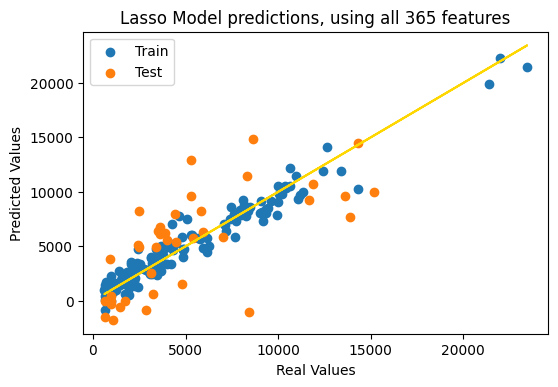

In [29]:
lm = linear_model.Lasso(alpha = 2)
model = lm.fit(x_train, y_train)
tests = lm.predict(x_test)
trains = lm.predict(x_train)
fig = plt.subplots(dpi = 100)
plt.scatter(y_train, trains, label = 'Train')
plt.scatter(y_test, tests, label = 'Test')

plt.plot(y_train, y_train, color="gold")
plt.ylabel('Predicted Values')
plt.xlabel('Real Values')
plt.title('Lasso Model predictions, using all 365 features')
plt.legend(loc = 'best')
plt.savefig('Lasso_predictions.png')
print('RMSE: ' + str(mean_squared_error(tests, y_test)**0.5), 'MAPE: ' + str(mean_absolute_percentage_error(tests, y_test)))

##### normalizing is better than standardizing 

### Random Forest

MSE: 2905.949388073086 MAPE: 0.32219463838926354


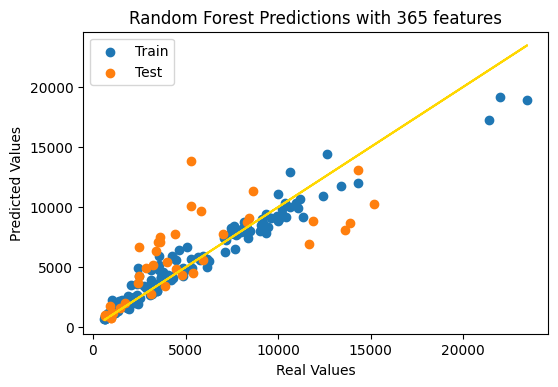

In [83]:
regr = RandomForestRegressor(max_depth=7, random_state=2)
regr.fit(x_train, y_train)

tests = regr.predict(x_test)
trains = regr.predict(x_train)

fig = plt.subplots(dpi = 100)
plt.scatter(y_train, trains, label = 'Train')
plt.scatter(y_test, tests, label = 'Test')

plt.plot(y_train, y_train,color="gold")
# plt.ylim(0, y_train['rpt_0.2Cdischarge_capacity0.8_real_regular_throughput::DiagnosticProperties'].max())
plt.ylabel('Predicted Values')
plt.xlabel('Real Values')
plt.title('Random Forest Predictions with 365 features')
plt.legend(loc = 'best')
print('MSE: ' + str(mean_squared_error(tests, y_test)**0.5), 'MAPE: ' + str(mean_absolute_percentage_error(tests, y_test)))

In [84]:
def random_forest_model(x_train, x_test, y_train, y_test):
    regr = RandomForestRegressor(max_depth=6, random_state=1)
    regr.fit(x_train, y_train)

    tests = regr.predict(x_test)
    trains = regr.predict(x_train)

    fig = plt.subplots(dpi = 150)
#     plt.scatter(y_train, trains, label = 'Train')
#     plt.scatter(y_test, tests, label = 'Test')

    plt.plot(y_train, y_train,color="gold")
    # plt.ylim(0, y_train['rpt_0.2Cdischarge_capacity0.8_real_regular_throughput::DiagnosticProperties'].max())
    plt.ylabel('Predicted Values')
    plt.xlabel('Real Values')
    plt.title('Random Forest Predictions with 365 features')
    plt.scatter(y_train, trains, label = 'Train' + ' MAPE:' + 
                "{:.2f}".format(mean_absolute_percentage_error(trains, y_train)) + 
                '|RMSE:' + "{:.0f}".format(mean_squared_error(trains, y_train)**0.5))
    plt.scatter(y_test, tests, label = 'Test ' + 'MAPE:' + 
                "{:.2f}".format(mean_absolute_percentage_error(tests, y_test)) + 
                '|RMSE:' + "{:.0f}".format(mean_squared_error(tests, y_test)**0.5))
    
    plt.legend(loc = 'best')

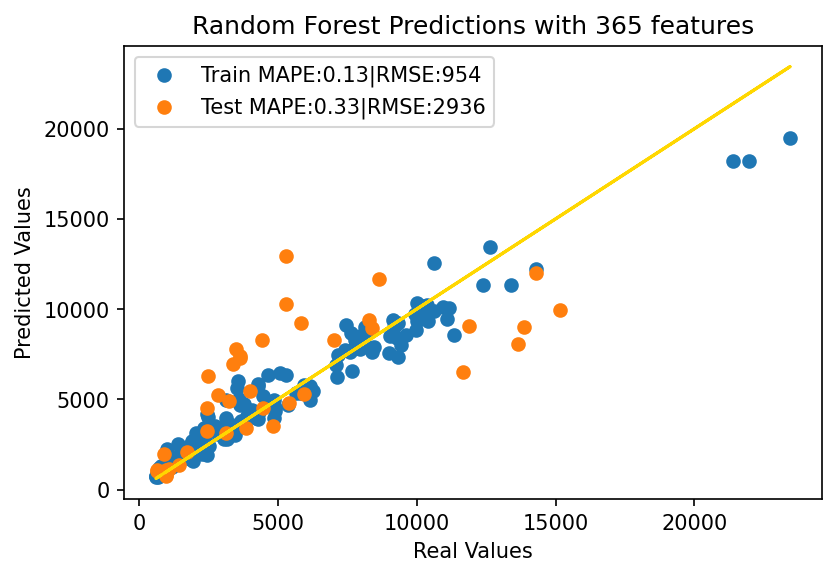

In [85]:
random_forest_model(x_train, x_test, y_train, y_test)

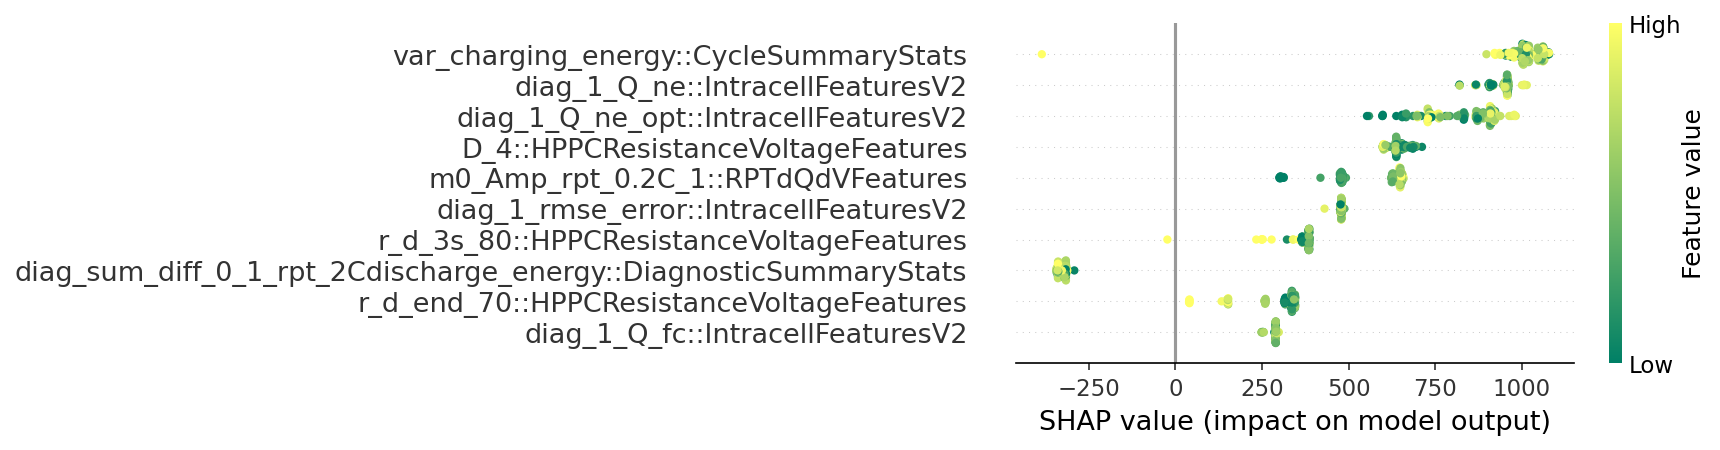

In [52]:
explainer = shap.TreeExplainer(regr)
shap_values = explainer(X_train)
fig = plt.subplots(dpi = 150)
shap.summary_plot(shap_values, X_train, max_display = 10, show=False, cmap='summer', plot_size=(6,3), sort=True)

### Neural Network 

In [34]:
model = Sequential()
model.add(Dense(400, input_dim=364, kernel_initializer='normal', activation='relu'))
#, activity_regularizer=regularizers.L2(0.01)
model.add(Dense(10, kernel_initializer='normal'))
model.add(Dense(1, kernel_initializer='normal'))

# Compile the model and calculate its accuracy:
model.compile(loss='mean_squared_error', optimizer='adam') 

# Print a summary of the Keras model:
# model.summary()

2022-06-02 18:22:47.321644: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-02 18:22:47.321753: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-23-91): /proc/driver/nvidia/version does not exist
2022-06-02 18:22:47.323254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
20/20 [==============================] - 0s 1ms/step - loss: 16467541.0000
Epoch 2/50
20/20 [==============================] - 0s 1ms/step - loss: 9731468.0000
Epoch 3/50
20/20 [==============================] - 0s 1ms/step - loss: 8183822.0000
Epoch 4/50
20/20 [==============================] - 0s 1ms/step - loss: 7083528.5000
Epoch 5/50
20/20 [==============================] - 0s 1ms/step - loss: 6487683.5000
Epoch 6/50
20/20 [==============================] - 0s 1ms/step - loss: 5864476.0000
Epoch 7/50
20/20 [==============================] - 0s 1ms/step - loss: 5468044.5000
Epoch 8/50
20/20 [==============================] - 0s 1ms/step - loss: 5126652.5000
Epoch 9/50
20/20 [==============================] - 0s 1ms/step - loss: 4862150.0000
Epoch 10/50
20/20 [==============================] - 0s 1ms/step - loss: 4576564.0000
Epoch 11/50
20/20 [==============================] - 0s 1ms/step - loss: 4356983.5000
Epoch 12/50
20/20 [==============================] - 0s 1ms/st

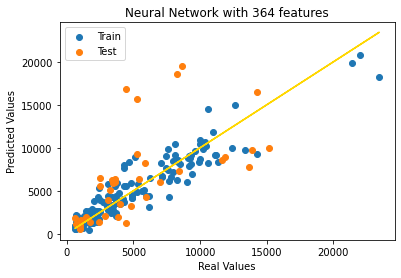

In [36]:
x_train = scaled_x_train
x_test = scaled_x_test

model.fit(x_train, y_train, epochs=50, batch_size=8)
tests = model.predict(x_test)
trains = model.predict(x_train)

plt.scatter(y_train, trains, label = 'Train')
plt.scatter(y_test, tests, label = 'Test')

plt.plot(y_train, y_train, color="gold")
plt.ylabel('Predicted Values')
plt.xlabel('Real Values')
plt.title('Neural Network with 364 features')
plt.legend(loc = 'best')
print(f'TRAIN: RMSE: {mean_squared_error(trains, y_train)**0.5}, MAPE: {mean_absolute_percentage_error(trains, y_train)}')
print(f'TEST: RMSE: {mean_squared_error(tests, y_test)**0.5}, MAPE: {mean_absolute_percentage_error(tests, y_test)}')
# print('MSE: ' + str(mean_squared_error(predictions, y_test)**0.5), 'MAPE: ' + str(mean_absolute_percentage_error(predictions, y_test)))

##### standardizing is better than normalizing 

### Kernel Method

In [76]:
np.array([1, 2, 3]).reshape(-1, 1)

array([[1],
       [2],
       [3]])

In [81]:
def kernel_model(x_train, x_test, y_train, y_test):

    scaled_x_train = np.concatenate((x_train, np.ones((x_train.shape[0], 1))), axis=-1)
    scaled_x_test = np.concatenate((x_test, np.ones((x_test.shape[0], 1))), axis=-1)

    rng = np.random.RandomState(0)
    krr = KernelRidge(alpha=0.32, kernel = 'laplacian')
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    krr.fit(scaled_x_train, y_train)
    predictions = krr.predict(scaled_x_test)
    trains = krr.predict(scaled_x_train)
    
#     X_train_summary = shap.sample(scaled_x_train, 10)
    
#     explainer = shap.KernelExplainer(krr.predict, data = X_train_summary)
#     shap_values = explainer(X_train_summary)
#     fig = plt.subplots(dpi = 150)
#     shap.summary_plot(shap_values, X_train, max_display = 10, show=False, cmap='summer', plot_size=(6,3), sort=True)

    fig = plt.subplots(dpi = 150)
    # trains = np.exp(trains)
    # predictions = np.exp(predictions)
    # plt.scatter(np.exp(y_train), trains, label = 'trainings')
    # plt.scatter(np.exp(y_test), predictions, label = 'predictions')

    plt.plot(y_train, y_train, color="gold")
    # plt.ylim(0, y_train['rpt_0.2Cdischarge_capacity0.8_real_regular_throughput::DiagnosticProperties'].max())
    plt.ylabel('Predicted Values')
    plt.xlabel('Real Values')
    plt.title('Kernel with 365 features')

#     print('RMSE: ' + str(mean_squared_error(predictions, y_test)**0.5), 'MAPE: ' + str(mean_absolute_percentage_error(predictions, y_test)))
    #mean_absolute_error(predictions, y_test)
    
    plt.scatter(y_train, trains, label = 'Train' + ' MAPE:' + 
                "{:.2f}".format(mean_absolute_percentage_error(trains, y_train)) + 
                '|RMSE:' + "{:.0f}".format(mean_squared_error(trains, y_train)**0.5))
    plt.scatter(y_test, predictions, label = 'Test ' + 'MAPE:' + 
                "{:.2f}".format(mean_absolute_percentage_error(predictions, y_test)) + 
                '|RMSE:' + "{:.0f}".format(mean_squared_error(predictions, y_test)**0.5))
    
    plt.legend(loc = 'best')

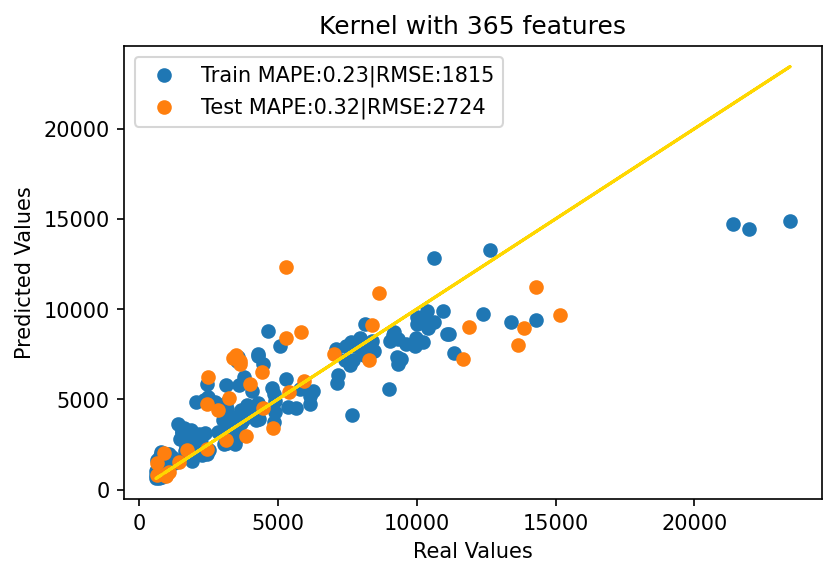

In [82]:
kernel_model(x_train, x_test, y_train, y_test)

MSE: 2698.1121149500946 MAPE: 0.31537951754569715


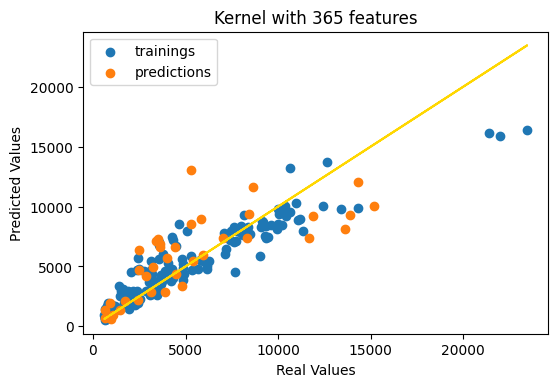

In [41]:
scaled_x_train = np.concatenate((x_train, np.ones((x_train.shape[0], 1))), axis=-1)
scaled_x_test = np.concatenate((x_test, np.ones((x_test.shape[0], 1))), axis=-1)

rng = np.random.RandomState(0)
krr = KernelRidge(alpha=0.2, kernel = 'laplacian')
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)
krr.fit(scaled_x_train, y_train)
predictions = krr.predict(scaled_x_test)
trains = krr.predict(scaled_x_train)

fig = plt.subplots(dpi = 100)
# trains = np.exp(trains)
# predictions = np.exp(predictions)
# plt.scatter(np.exp(y_train), trains, label = 'trainings')
# plt.scatter(np.exp(y_test), predictions, label = 'predictions')

plt.scatter(y_train, trains, label = 'trainings')
plt.scatter(y_test, predictions, label = 'predictions')

plt.plot(y_train, y_train, color="gold")
# plt.ylim(0, y_train['rpt_0.2Cdischarge_capacity0.8_real_regular_throughput::DiagnosticProperties'].max())
plt.ylabel('Predicted Values')
plt.xlabel('Real Values')
plt.title('Kernel with 365 features')
plt.legend(loc = 'best')

print('MSE: ' + str(mean_squared_error(predictions, y_test)**0.5), 'MAPE: ' + str(mean_absolute_percentage_error(predictions, y_test)))
#mean_absolute_error(predictions, y_test)

##### standardizing or normalizing have similar performance 

### Cross validation

In [43]:
X = np.concatenate((X_train.to_numpy(), X_test.to_numpy()))
y = np.concatenate((y_train.to_numpy(), y_test.to_numpy()))

1687772589.752465 -127.44842905937249


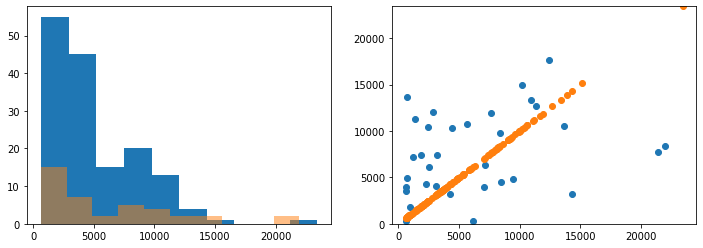

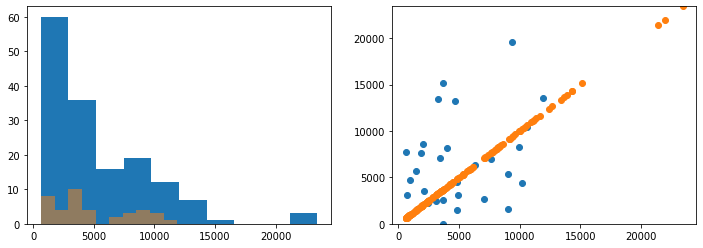

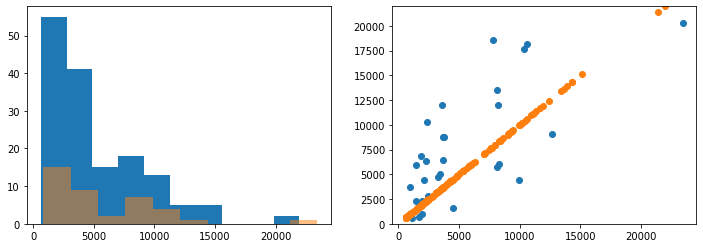

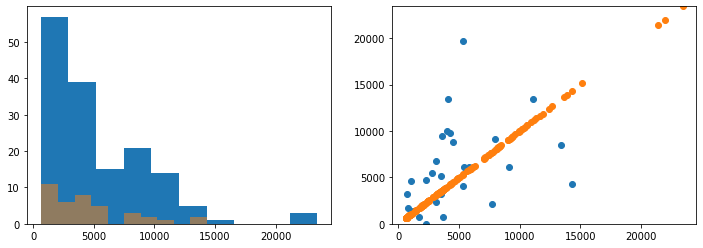

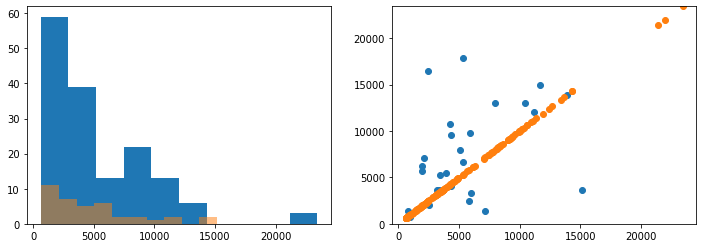

In [71]:
kf = KFold(n_splits=5, shuffle = True) # split into 5 folds 
kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
errors = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    fig, ax = plt.subplots(1,2, figsize=(2*6, 1*4) )
    ax[0].hist(y_train)
    ax[0].hist(y_test, alpha = 0.5)
    lm = linear_model.LinearRegression()
    model = lm.fit(X_train, y_train)
    predictions = lm.predict(X_test)
    error = mean_squared_error(predictions, y_test)
    errors.append(error)
    ax[1].scatter(y_test, predictions, label = 'predictions')
    ax[1].scatter(y_train, lm.predict(X_train), label = 'trainings')
    ax[1].set_ylim(0, y_train.max())
score=cross_val_score(lm,X_train,y_train,cv=kf)

print(np.mean(errors),score.mean())

#### First correlation test with Variance feature (Severson 2019)

In [9]:
variance_feat = x_train['var_discharging_capacity::CycleSummaryStats'].tolist()
train_labels= y_train["rpt_0.2Cdischarge_capacity0.8_real_regular_throughput::DiagnosticProperties"].tolist()

-0.6100447029609648


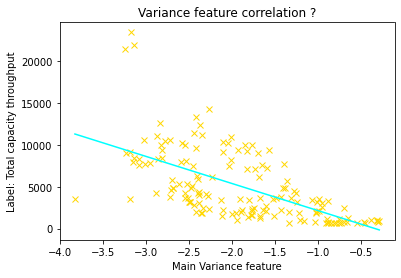

In [10]:
a,b = np.polyfit(variance_feat, train_labels,1 )
plt.plot(variance_feat, train_labels,'x',color='gold')
plt.plot([min(variance_feat),max(variance_feat)],[min(variance_feat)*a+b,a*max(variance_feat)+b],color = "cyan")
plt.xlabel('Main Variance feature')
plt.ylabel('Label: Total capacity throughput')
plt.title('Variance feature correlation ?')

coef = np.corrcoef(variance_feat,train_labels)[0,1]
print(coef)

In [11]:
##For comparison, the non_log feature of the variance is not as good:
non_log_feat = np.exp(np.asarray(variance_feat))
coef = np.corrcoef(non_log_feat,train_labels)[0,1]
print (coef)

-0.5459908068807883


#### Automating calculations of all correlation coeff for all features

In [27]:
def get_coef (feat,labels, plot = False):
    ### input: feature list, labels list, 
    ### return correlation coef between the feature and the labels
    
    a,b = np.polyfit(feat,labels,1 )
    coef = np.corrcoef(variance_feat,train_labels)[0,1]
    if plot:
        plt.plot(feat, labels,'x',color='gold')
        plt.plot([min(feat),max(feat)],[min(feat)*a+b,a*max(feat)+b],color = "cyan")
        plt.xlabel('Main Variance feature')
        plt.ylabel('Label: Total capacity throughput')
        plt.title('Variance feature correlation ?')
        print (f'correlation coef between the feature and the labels is {coef}')
    return coef

In [28]:
get_coef(variance_feat,train_labels)

-0.6100447029609648

In [49]:
#next :
coef_dict ={}
i=0
for key in x_train.keys():
    if i== 0:#first is filename...
        i+=1
        continue
    feature= x_train[key].tolist()
    coef = np.corrcoef(feature, train_labels)[0,1]
    coef_dict[key]=abs(coef)

coef_dict = dict(sorted(coef_dict.items(), key=lambda item: item[1],reverse=True))

##printing a few: 
i=0
for key in coef_dict.keys():
    if i<10:
        print(f'feature: {key} gives a correlation of {coef_dict[key]}')
        i+=1
    
# print(f'First examples of the coef_dict are {list(coef_dict.items())[:10]}')


feature: abs_discharging_capacity::CycleSummaryStats gives a correlation of 0.7587100552701532
feature: square_discharging_capacity::CycleSummaryStats gives a correlation of 0.7299191120436507
feature: abs_mean_discharge_capacity_difference_cycles_2:100::DeltaQFastCharge gives a correlation of 0.7219953391133521
feature: mean_discharging_capacity::CycleSummaryStats gives a correlation of 0.7218496725963969
feature: abs_charging_capacity::DiagnosticSummaryStats gives a correlation of 0.6839188370424999
feature: abs_charging_energy::DiagnosticSummaryStats gives a correlation of 0.681545930799766
feature: abs_min_discharge_capacity_difference_cycles_2:100::DeltaQFastCharge gives a correlation of 0.6703448832561698
feature: diag_1_pe_voltage_FC4p2V::IntracellFeaturesV2 gives a correlation of 0.6651322632746888
feature: D_4::HPPCResistanceVoltageFeatures gives a correlation of 0.6487567927233764
feature: abs_variance_discharge_capacity_difference_cycles_2:100::DeltaQFastCharge gives a corre